In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
print sns.__version__
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self, ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

3
0.7.0


In [2]:
# Set up console so we can reattach via terminal ipython later. See:
# https://stackoverflow.com/questions/19479645/using-ipython-console-along-side-ipython-notebook

%qtconsole

# Then do `ipython console --existing` in a terminal to connect and have access to same data!
# But note, do not do CTRL-D in that terminal or it will kill the kernel!

In [3]:
def plotInputVsMeasuredFluxes(testObj, img=1, plotSNR=False):
    src = None
    if img == 1:
        src1 = testObj.im1.doDetection(threshold=3.0)
        src1 = src1[~src1['base_PsfFlux_flag']]
        src = src1
    elif img == 2:
        src2 = testObj.im2.doDetection(threshold=3.0)
        src2 = src2[~src2['base_PsfFlux_flag']]
        src = src2
    elif img == 3:
        src3 = dit.doDetection(testObj.res.subtractedExposure, threshold=3.0)
        src3 = src3[~src3['base_PsfFlux_flag']]
        src = src3
    elif img == 4:
        src4 = testObj.D_ZOGY.doDetection(threshold=3.0)
        src4 = src4[~src4['base_PsfFlux_flag']]
        src = src4

    dist = np.sqrt(np.add.outer(src.base_NaiveCentroid_x, -testObj.centroids[:, 0])**2. + \
                   np.add.outer(src.base_NaiveCentroid_y, -testObj.centroids[:, 1])**2.) # in pixels
    matches = np.where(dist <= 1.5)
    true_pos = len(np.unique(matches[0]))
    false_neg = testObj.centroids.shape[0] - len(np.unique(matches[1]))
    false_pos = src.shape[0] - len(np.unique(matches[0]))
    detections = {'TP': true_pos, 'FN': false_neg, 'FP': false_pos}
    print detections

    src_hits1 = src.iloc[matches[0],:]
    input_hits1 = testObj.centroids[matches[1],:]
    fluxes = input_hits1[:,2]
    if img == 2 or img == 3 or img == 4:
        fluxes = input_hits1[:,3]

    if not plotSNR:
        plt.scatter(fluxes, src_hits1.base_PsfFlux_flux.values, label='PsfFlux')
        plt.scatter(fluxes, src_hits1.base_PeakLikelihoodFlux_flux.values, label='PeakLikelihoodFlux', color='r')
        plt.legend(loc='upper left', shadow=True)
        #plt.xlim(0, 20000)
        #plt.ylim(0, 40000)
    else:
        try:
            print fluxes[fluxes>0].min(), (src_hits1.base_PsfFlux_flux.values/src_hits1.base_PsfFlux_fluxSigma.values).min()
        except:
            pass
        plt.scatter(fluxes, src_hits1.base_PsfFlux_flux.values/src_hits1.base_PsfFlux_fluxSigma.values)
        #plt.xlim(0, 32000);
    
    return {'input': fluxes, 'psfFlux': src_hits1.base_PsfFlux_flux.values,
            'psfFluxSigma': src_hits1.base_PsfFlux_fluxSigma.values,
            'peakLikelihoodFlux': src_hits1.base_PeakLikelihoodFlux_flux.values}

In [4]:
reload(dit)

testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(200, 20000), 
                         varFlux2=np.linspace(200, 2000, 200),
                        templateNoNoise=False, skyLimited=True)
res = testObj.runTest()
print res

{'ZOGY': {'FP': 10, 'FN': 107, 'TP': 93}, 'ALstack': {'FP': 5, 'FN': 113, 'TP': 87}, 'SZOGY': {'FP': 15, 'FN': 112, 'TP': 88}, 'ALstack_decorr': {'FP': 7, 'FN': 114, 'TP': 86}}


{'FP': 87, 'FN': 383, 'TP': 114}


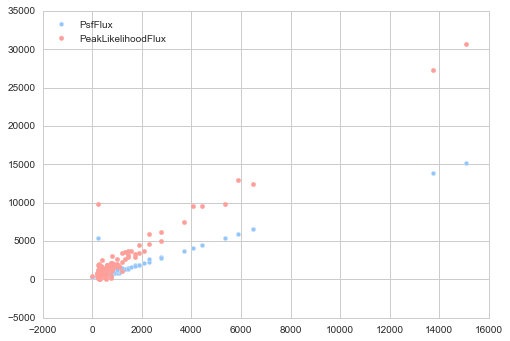

In [5]:
tmp = plotInputVsMeasuredFluxes(testObj, img=1)

{'FP': 56, 'FN': 367, 'TP': 128}


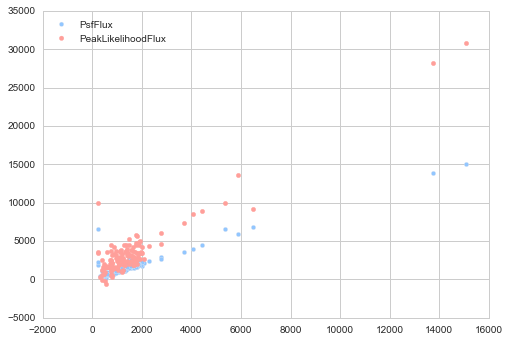

In [6]:
plotInputVsMeasuredFluxes(testObj, img=2);

1.98549309142
1.05907306845


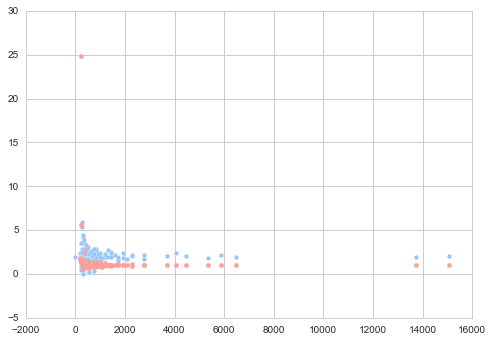

In [7]:
print np.median(tmp['peakLikelihoodFlux']/tmp['psfFlux'])
print np.median(tmp['psfFlux']/tmp['input'])
plt.scatter(tmp['input'], tmp['peakLikelihoodFlux']/tmp['psfFlux'])
plt.scatter(tmp['input'], tmp['psfFlux']/tmp['input'], color='r')

{'FP': 87, 'FN': 383, 'TP': 114}
200.0 1.74377732794


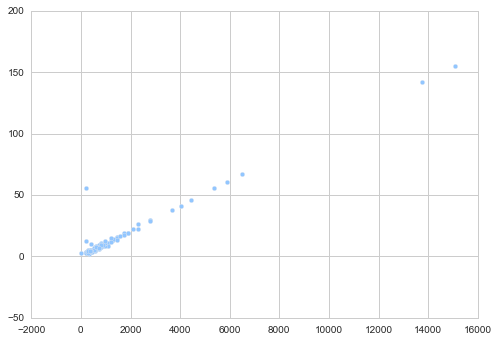

In [8]:
plotInputVsMeasuredFluxes(testObj, img=1, plotSNR=True);

{'FP': 56, 'FN': 367, 'TP': 128}
219.708228398 1.90973253321


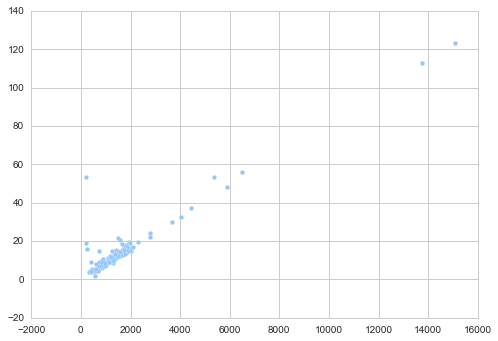

In [9]:
plotInputVsMeasuredFluxes(testObj, img=2, plotSNR=True);

{'FP': 52, 'FN': 407, 'TP': 91}
219.708228398 4.79998651066


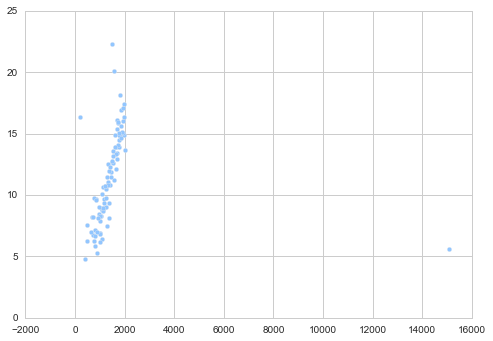

In [10]:
tmp = plotInputVsMeasuredFluxes(testObj, img=3, plotSNR=True)

{'FP': 80, 'FN': 407, 'TP': 91}
219.708228398 0.15475335527


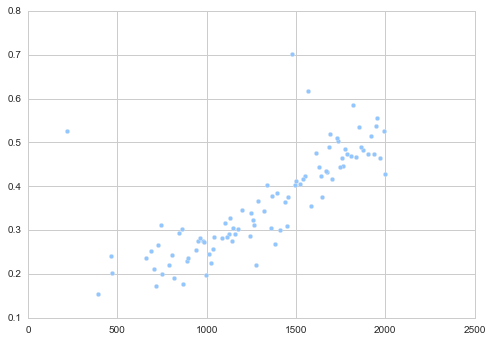

In [11]:
tmp = plotInputVsMeasuredFluxes(testObj, img=4, plotSNR=True)

In [12]:
reload(dit)

testObj = dit.DiffimTest(n_sources=510, sourceFluxRange=(500, 120000), 
                         varFlux2=np.linspace(500, 5000, 500),
                         templateNoNoise=False, skyLimited=True,
                         variablesNearCenter=False,
                         verbose=False)
res = testObj.runTest(returnSources=True)
sources = res['sources']
del res['sources']
print res

{'ZOGY': {'FP': 26, 'FN': 355, 'TP': 142}, 'ALstack': {'FP': 15, 'FN': 385, 'TP': 112}, 'SZOGY': {'FP': 31, 'FN': 364, 'TP': 132}, 'ALstack_decorr': {'FP': 13, 'FN': 332, 'TP': 163}}


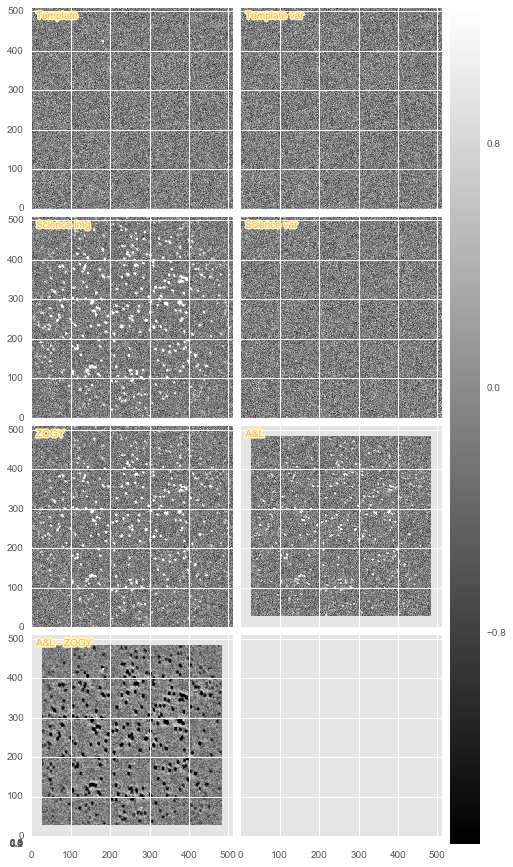

In [13]:
fig = plt.figure(1, (15, 15))
testObj.doPlot(nrows_ncols=(5, 2))

{'FP': 38, 'FN': 423, 'TP': 84}


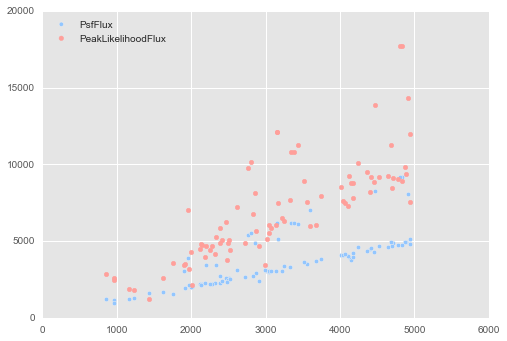

In [14]:
tmp = plotInputVsMeasuredFluxes(testObj, img=3, plotSNR=False)

{'FP': 38, 'FN': 423, 'TP': 84}
860.721442886 8.07469778808


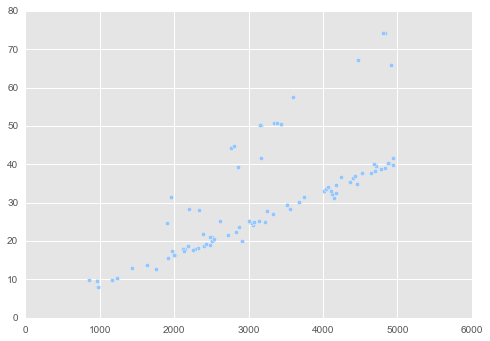

In [15]:
tmp = plotInputVsMeasuredFluxes(testObj, img=3, plotSNR=True)

{'FP': 59, 'FN': 389, 'TP': 118}
572.144288577 0.168879403075


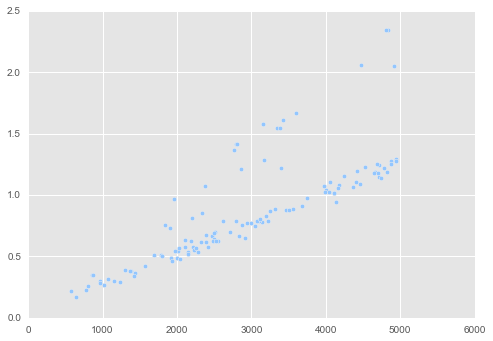

In [16]:
tmp = plotInputVsMeasuredFluxes(testObj, img=4, plotSNR=True)

OK, let's implement forced-phot.

Use https://github.com/lsst-dm/dmtn-006/blob/master/python/forcePhotDiaSources.py as a reference. Start with the "input" catalog of sources from `testObj`.

See https://github.com/djreiss/lsst-dipole/blob/master/notebooks/7b.%20test%20new%20(fixed!)%20and%20ip_diffim%20dipole%20fitting%20on%20same%20sources-Copy3%20(more%20realistic%20noise).ipynb for how to create a sourceTable.

Or see @mwv's script here: https://github.com/wmwv/twinkles_subtractions/blob/master/forcedPhotExternalCatalog.py

also here: https://community.lsst.org/t/adding-columns-and-concatenating-afw-tables/1382/2

Columns are: `x`, `y`, `flux`, `flux2` (where 1 and 2 are template and science, respectively)

In [17]:
centroids = testObj.centroids
sizeme(pd.DataFrame(centroids).head())

,0,1,2,3
0,4.061888,176.993043,0.0,1284.569138
1,19.916663,421.773922,0.0,878.757515
2,50.287147,473.795381,0.0,716.432866
3,73.356951,383.113252,0.0,2375.751503
4,398.989444,139.545897,0.0,3187.374749


In [154]:
import lsst.afw.table as afwTable
schema = afwTable.SourceTable.makeMinimalSchema()
centroidKey = afwTable.Point2DKey.addFields(schema, 'centroid', 'centroid', 'pixel')
schema.getAliasMap().set('slot_Centroid', 'centroid')
#schema.addField('centroid_x', type=float, doc='x pixel coord')
#schema.addField('centroid_y', type=float, doc='y pixel coord')
schema.addField('inputFlux_template', type=float, doc='input flux in template')
schema.addField('inputFlux_science', type=float, doc='input flux in science image')
table = afwTable.SourceTable.make(schema)
sources = afwTable.SourceCatalog(table)

In [155]:
import lsst.afw.geom as afwGeom
import lsst.afw.detection as afwDetection

footprint_radius = 5  # pixels
exposure = testObj.im2.asAfwExposure()
expWcs = exposure.getWcs()

for row in centroids:
    record = sources.addNew()
    coord = expWcs.pixelToSky(row[0], row[1])
    record.setCoord(coord)
    record.set(centroidKey, afwGeom.Point2D(row[0], row[1]))
    record.set('inputFlux_template', row[2])
    record.set('inputFlux_science', row[3])
    #print record.getCentroid()
    
    #print expWcs.skyToPixel(coord), type(expWcs.skyToPixel(coord)), row
    fpCenter = afwGeom.Point2I(afwGeom.Point2D(row[0], row[1])) #expWcs.skyToPixel(coord))
    footprint = afwDetection.Footprint(fpCenter, footprint_radius)
    record.setFootprint(footprint)
    
print sources.schema.getNames()
am = sources.schema.getAliasMap()
print am.keys(), am.values()    

sources = sources.copy(deep=True)  # make it contiguous
tmp = pd.DataFrame({col: sources.columns[col] for col in sources.schema.getNames()})
sizeme(tmp.head())

('centroid_x', 'centroid_y', 'coord_dec', 'coord_ra', 'id', 'inputFlux_science', 'inputFlux_template', 'parent')
['slot_Centroid'] ['centroid']


,centroid_x,centroid_y,coord_dec,coord_ra,id,inputFlux_science,inputFlux_template,parent
0,4.061888,176.993043,0.928165,3.761354,1,1284.569138,0.0,0
1,19.916663,421.773922,0.927946,3.761380,2,878.757515,0.0,0
2,50.287147,473.795381,0.927900,3.761425,3,716.432866,0.0,0
3,73.356951,383.113252,0.927980,3.761459,4,2375.751503,0.0,0
4,398.989444,139.545897,0.928193,3.761942,5,3187.374749,0.0,0


In [ ]:
plt.scatter(sources['centroid_x'], sources['centroid_y'])

In [ ]:
plt.scatter(sources['coord_ra'], sources['coord_dec'])
plt.xlim(3.7613, 3.7622)
plt.ylim(0.9278, 0.9284)

In [156]:
config = measBase.ForcedMeasurementTask.ConfigClass() #ForcedExternalCatalogMeasurementTask.ConfigClass()
config.plugins.names = ["base_TransformedCentroid", "base_PsfFlux"]
config.slots.shape = None
config.slots.centroid = "base_TransformedCentroid"
config.slots.modelFlux = "base_PsfFlux"
measurement = measBase.ForcedMeasurementTask(schema, config=config)
measCat = measurement.generateMeasCat(exposure, sources, expWcs)
measurement.attachTransformedFootprints(measCat, sources, exposure, expWcs)
measurement.run(measCat, exposure, sources, expWcs)

In [157]:
tmp = pd.DataFrame({col: measCat.columns[col] for col in measCat.schema.getNames()})
sizeme(tmp.head())

,base_PsfFlux_flag,base_PsfFlux_flag_edge,base_PsfFlux_flag_noGoodPixels,base_PsfFlux_flux,base_PsfFlux_fluxSigma,base_TransformedCentroid_x,base_TransformedCentroid_y,coord_dec,coord_ra,id,objectId,parent,parentObjectId
0,True,True,False,1402.897109,122.469380,4.061888,176.993043,NaN,NaN,1,1,0,0
1,False,False,False,779.285547,121.955061,19.916663,421.773922,NaN,NaN,2,2,0,0
2,False,False,False,877.208674,122.613647,50.287147,473.795381,NaN,NaN,3,3,0,0
3,False,False,False,3988.657110,123.666030,73.356951,383.113252,NaN,NaN,4,4,0,0
4,False,False,False,3470.346001,121.605925,398.989444,139.545897,NaN,NaN,5,5,0,0


In [153]:
tmp = pd.DataFrame({col: sources.columns[col] for col in sources.schema.getNames()})
sizeme(tmp.head())

,centroid_x,centroid_y,coord_dec,coord_ra,id,inputFlux_science,inputFlux_template,parent
0,4.061888,176.993043,0.928165,3.761354,1,1284.569138,0.0,0
1,19.916663,421.773922,0.927946,3.761380,2,878.757515,0.0,0
2,50.287147,473.795381,0.927900,3.761425,3,716.432866,0.0,0
3,73.356951,383.113252,0.927980,3.761459,4,2375.751503,0.0,0
4,398.989444,139.545897,0.928193,3.761942,5,3187.374749,0.0,0


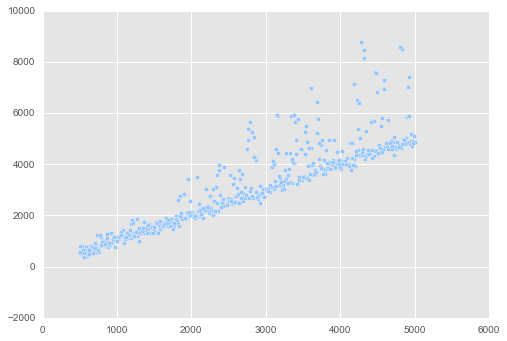

In [159]:
plt.scatter(sources['inputFlux_science'], measCat['base_PsfFlux_flux'])

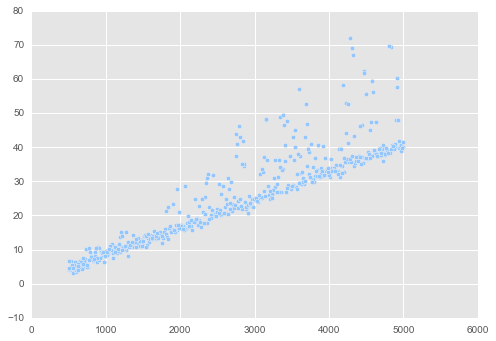

In [160]:
plt.scatter(sources['inputFlux_science'], measCat['base_PsfFlux_flux']/measCat['base_PsfFlux_fluxSigma'])